## Question 3: Real or Fake Solution 3

Start by checking internet connection and accessing the fastai library

In [1]:
# NB: This code is heavily based on the fast.ai bird classifier example.
#    This code is only here to check that your internet is enabled.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

## Step 1: Import the dataset

Get real/fake images from repository. Note that due to the high number of images (10,000), only a portion of the entire training set and testing set could be downloaded.

In [3]:
from fastcore.all import *
from fastai.vision.all import *

path = Path('archive/train')

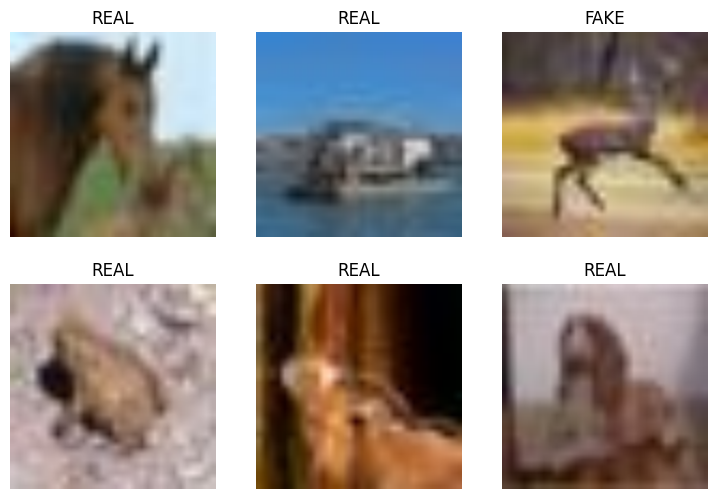

In [4]:
# Create the data loaders and ensure the images are the same size (192x192) by 'squish'. Reserve 20% of the images for testing.
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

# Show an example batch of 6 images
dls.show_batch(max_n=6)

Apply fine tuning to resnet50

In [5]:
# Use resnet50 train as a reference and fine tune the model
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(3)

/home/vscode/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Plot the confusion matrix so far

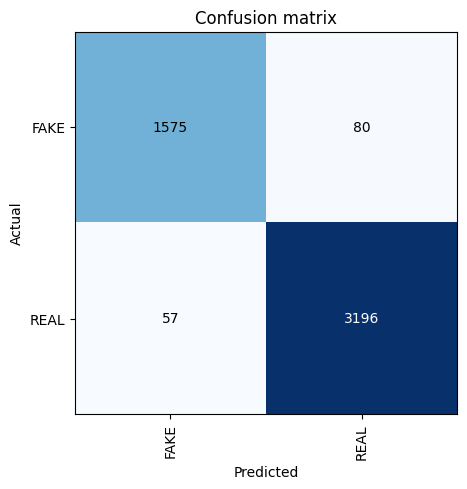

In [6]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Export the model

In [7]:
learn.export('model_3.pkl')

# Step 2: Testing

Load the exported model

In [2]:
model = load_learner('model_3.pkl')

Create dataloaders for the test set

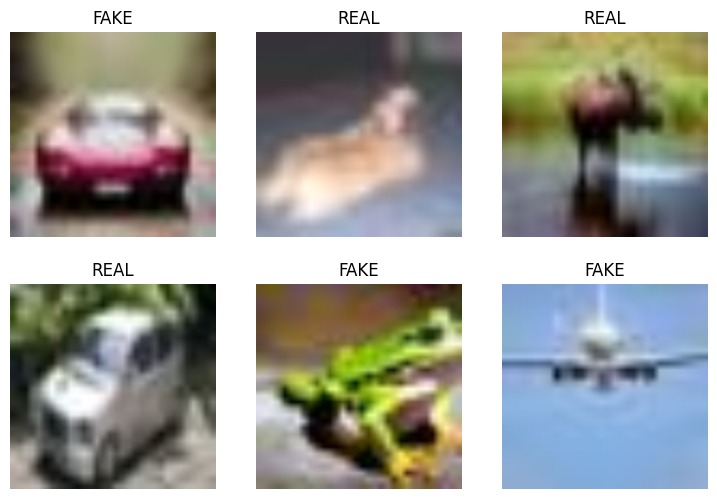

In [3]:
# Create the data loaders and ensure the images are the same size (192x192) by 'squish'. Reserve 10% of the images for testing.
# Set the path to your test set
test_path = Path('archive/test')

test_dataloader = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(test_path)

# Show an example batch of 6 images
test_dataloader.show_batch(max_n=6)

Evaluate the model

In [4]:
# Set the model to evaluation mode
model.eval()

# Initialize lists for storing predictions and targets
all_predictions = []
all_targets = []

# Iterate over the test dataloader
for batch in test_dataloader.valid:
    inputs, targets = batch

    # Forward pass
    with torch.no_grad():
        outputs = model.forward(inputs)  # Make sure to use the correct forward method

    # Apply softmax to get probabilities
    probabilities = torch.softmax(outputs, dim=1)

    # Get predicted labels
    _, predictions = torch.max(probabilities, dim=1)

    # Append predictions and targets to the lists
    all_predictions.extend(predictions.tolist())
    all_targets.extend(targets.tolist())

# Convert the predictions and targets to tensors
all_predictions = torch.tensor(all_predictions)
all_targets = torch.tensor(all_targets)

# Convert tensor labels to class labels
class_labels = test_dataloader.vocab[all_predictions]

# Print the predicted labels
print(class_labels)

['REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'FAKE', 'REAL', 'REAL',

Compute the accuracy

In [11]:
# Calculate accuracy
correct_predictions = (all_predictions == all_targets).sum().item()
total_predictions = len(all_predictions)
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy:.2%}")

Accuracy: 50.43%


Test individual images

In [12]:
is_real,_,probs = model.predict(PILImage.create('archive/test/REAL/0004 (8).jpg'))
print(f"This is: {is_real}.")
print(f"Probability it's fake: {probs[0]:.4f}")
print(f"Probability it's real: {probs[1]:.4f}")

This is: REAL.
Probability it's fake: 0.0055
Probability it's real: 0.9945


The above code for testing was heavily inspired by answers given by ChatGPT

# Discussion of results for these solutions:

After trying many different neural network architectures based on the graph below, it was found that of the built-in models, only the smaller ResNet models seemed to work. Models like these are broadly compatible for a variety of functions and are used as a baseline for training a model for a specific task. These pretrained models are also shown below. The method used in all three solutions for training was `fine_tune`, although `fit` could work as well.

Interestingly, it was observed that the supposedly 'higher accuracy' ResNet models provided less accuracy despite taking much longer to train; whereas `resnet18` took around half an hour for 60% accuracy, `resnet38` took around 45 minutes for 48% accuracy and `resnet50` took around 110 minutes for 50% accuracy. This may be due to a variety of factors such as the advanced level of refinement in the more accurate ResNet models being less generalised than `resnet18`. Additionally, the quality of the images in the dataset were rather poor which could make the deep learning process much more difficult. Many of the images were also exluded due to import issues caused by the massive volume of images.

In addition, the method for calculating accuracy was heavily influenced by ChatGPT generated code. Attempts were made to use the `model.metrics` method but to little success.

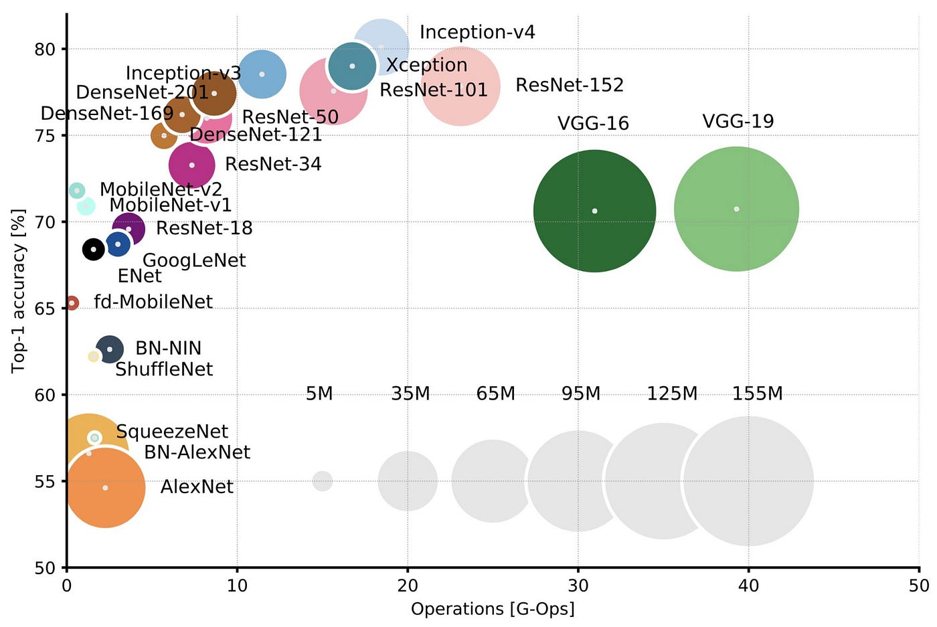

In [7]:
perf = 'DL_perf.jpg'

from fastai.vision.all import *
im = Image.open(perf)
im.to_thumb(1400,937)

source: https://towardsdatascience.com/neural-network-architectures-156e5bad51ba

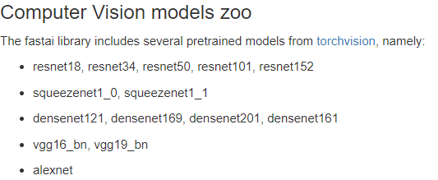

In [8]:
vision_models = 'vision_models.PNG'

im = Image.open(vision_models)
im.to_thumb(1066,438)

source: https://fastai1.fast.ai/vision.models.html